In [1]:
import json
import pandas as pd
import numpy as np
import numpy
import matplotlib.pyplot as plt
import cv2
import cv2 as cv
from PIL import Image, ImageDraw, ImageFilter
from tensorflow.keras.models import load_model 
from scipy import ndimage
from imutils.object_detection import non_max_suppression 
import random

In [2]:
with open('eval.json') as json_file:
    data = json.load(json_file)

In [3]:
categories_data = pd.DataFrame(data['categories'])
display(categories_data.style.background_gradient(cmap='Blues', axis=0))

,id,name
0,1,Регистрация (постановка на учет)
1,2,Снятие с учета


In [4]:
images_data = pd.DataFrame(data['images'])
images_data = images_data.rename(columns={'id': 'image_id'})
display(images_data.iloc [np.r_[0:7, (len(images_data)-7):len(images_data),:]].style.background_gradient(cmap='Blues', axis=0))

,width,height,image_id,file_name
0,2481,3507,0,85942.jpg
1,2456,3483,1,83393.jpg
2,1973,3508,2,83367.jpg
3,2631,3508,3,83283.jpg
4,2456,3483,4,83281.jpg
5,2631,3508,5,83277.jpg
6,1163,1600,6,83275.jpg
653,2631,3508,653,85980.jpg
654,2631,3508,654,85976.jpg
655,2631,3508,655,85972.jpg


In [5]:
images_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   width      660 non-null    int64 
 1   height     660 non-null    int64 
 2   image_id   660 non-null    int64 
 3   file_name  660 non-null    object
dtypes: int64(3), object(1)
memory usage: 20.8+ KB


In [6]:
k = 0
for i in range(0, len(images_data)):
    try:
        f = images_data.loc[images_data['image_id'] == i, 'file_name'].iloc[0]
        img = cv2.imdecode(np.fromfile('images/'+ f, dtype=np.uint8), 1)
    except FileNotFoundError:
        print('\u001b[38;5;19m', f'Не найден файл в папке images: {f} image_id = {i}', '\u001b[0m')
        k += 1
        images_data = images_data.loc[images_data['image_id'] != i]

 Не найден файл в папке images: 85942.jpg image_id = 0 
 Не найден файл в папке images: 83367.jpg image_id = 2 
 Не найден файл в папке images: 83283.jpg image_id = 3 
 Не найден файл в папке images: 83277.jpg image_id = 5 
 Не найден файл в папке images: 83269.jpg image_id = 7 
 Не найден файл в папке images: 83263.jpg image_id = 8 
 Не найден файл в папке images: 83250.jpg image_id = 13 
 Не найден файл в папке images: 83246.jpg image_id = 14 
 Не найден файл в папке images: 83240.jpg image_id = 16 
 Не найден файл в папке images: 83234.jpg image_id = 18 
 Не найден файл в папке images: 83344.jpg image_id = 21 
 Не найден файл в папке images: 83341.jpg image_id = 22 
 Не найден файл в папке images: 83335.jpg image_id = 24 
 Не найден файл в папке images: 83333.jpg image_id = 25 
 Не найден файл в папке images: 83321.jpg image_id = 29 
 Не найден файл в папке images: 83319.jpg image_id = 30 
 Не найден файл в папке images: 83316.jpg image_id = 31 
 Не найден файл в папке images: 83313

In [7]:
print('\u001b[38;5;19m', f'Удалили из списка отсутствующие файлы\n Количество отсутствующих файлов изображения: {k}', '\u001b[0m')

 Удалили из списка отсутствующие файлы
 Количество отсутствующих файлов изображения: 351 


In [8]:
images_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 309 entries, 1 to 657
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   width      309 non-null    int64 
 1   height     309 non-null    int64 
 2   image_id   309 non-null    int64 
 3   file_name  309 non-null    object
dtypes: int64(3), object(1)
memory usage: 12.1+ KB


In [9]:
list_image_id = images_data['image_id'].tolist()

In [10]:
emnist_labels_1 = [-90, 0, 90, 180]
model_1 = load_model('model_registration_recognition.keras')
model_2 = load_model('model_fraction_area.keras')

In [11]:
for i in list_image_id:
    f = images_data.loc[images_data['image_id'] == i, 'file_name'].iloc[0]
    img = cv2.imdecode(np.fromfile('images/'+ f, dtype=np.uint8), 1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = Image.fromarray(gray, mode=None) 
    fixed_len = 512
    draw = ImageDraw.Draw(img) 
    width, height = img.size
    width = img.size[0] 
    height = img.size[1] 
    if width >= height:
        ratio = (fixed_len+1)/float(img.size[0])
        new_height = int(ratio * img.size[1])
        new_size = (fixed_len+1, new_height)
    else:
        ratio = (fixed_len+1)/float(img.size[1])
        new_width = int(ratio * img.size[0])
        new_size = (new_width, fixed_len+1)
    img = img.resize(new_size)
    
    sharp_img = img.filter(ImageFilter.SHARPEN)
    img = sharp_img.resize((fixed_len, fixed_len))
    img = np.asarray(img)
    img = np.array(img)/255
    img = np.expand_dims(img, axis=0)
    predict = model_1.predict(img)
    result = np.argmax(predict, axis=1)
    num = emnist_labels_1[result[0]]
    images_data.loc[images_data['image_id'] == i, 'rotate'] = num

    predict = model_2.predict(img)
    result = np.argmax(predict, axis=1)
    mid_box = result[0]
    images_data.loc[images_data['image_id'] == i, 'fraction'] = mid_box 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━

In [12]:
images_data['rotate'] = images_data['rotate'].astype(int)
images_data['fraction'] = images_data['fraction'].astype(int)
display(images_data.iloc [np.r_[0:7, (len(images_data)-7):len(images_data),:]].style.background_gradient(cmap='Blues', axis=0))

,width,height,image_id,file_name,rotate,fraction
1,2456,3483,1,83393.jpg,90,3
4,2456,3483,4,83281.jpg,-90,19
6,1163,1600,6,83275.jpg,0,19
9,2456,3483,9,83259.jpg,0,19
10,1024,768,10,83257.jpg,0,7
11,1654,2338,11,83255.jpg,0,14
12,828,645,12,83252.jpg,0,5
645,3507,2481,645,86025.jpg,0,5
646,1700,2338,646,86022.jpg,0,19
651,960,1280,651,85985.jpg,90,4


In [13]:
def pertran(gray, apd_fix):
    pts = list()
    pts = [(apd_fix[0][0][0], apd_fix[0][0][1]), 
           (apd_fix[1][0][0], apd_fix[1][0][1]), 
           (apd_fix[2][0][0], apd_fix[2][0][1]), 
           (apd_fix[3][0][0], apd_fix[3][0][1])]
    
    rect = np.zeros((4, 2), dtype = "float32")
    s = np.sum(pts, axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    dst = np.array([
    		[0, 0],
            [400, 0],
            [400, 230],
            [0, 230]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(gray, M, (401, 231))
    return warped

In [22]:
list_img = [4, 432, 376, 212, 251, 239, 635]

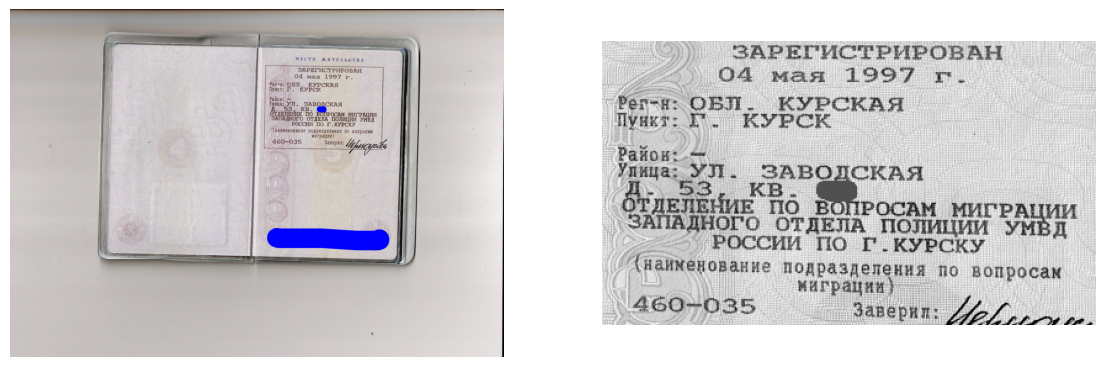

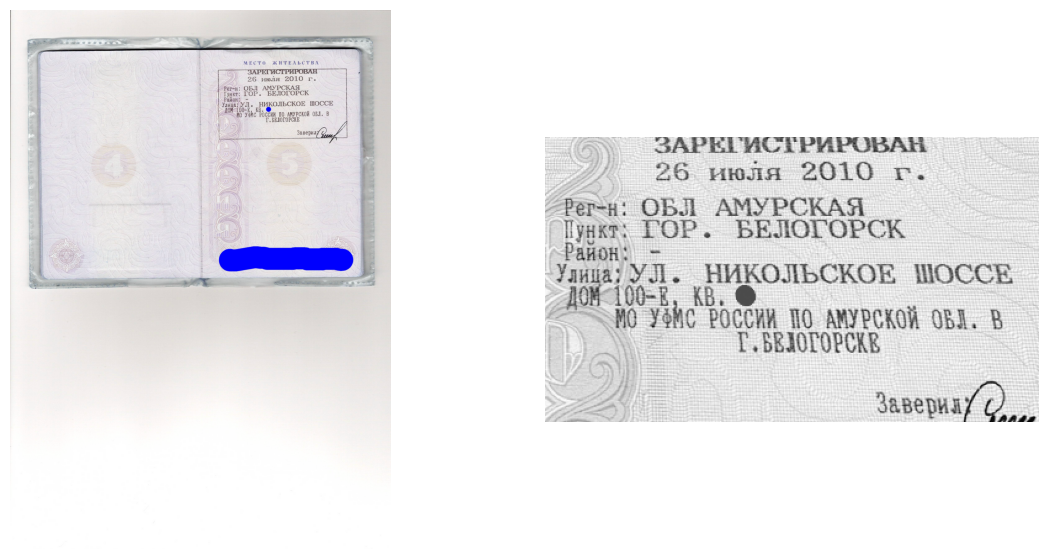

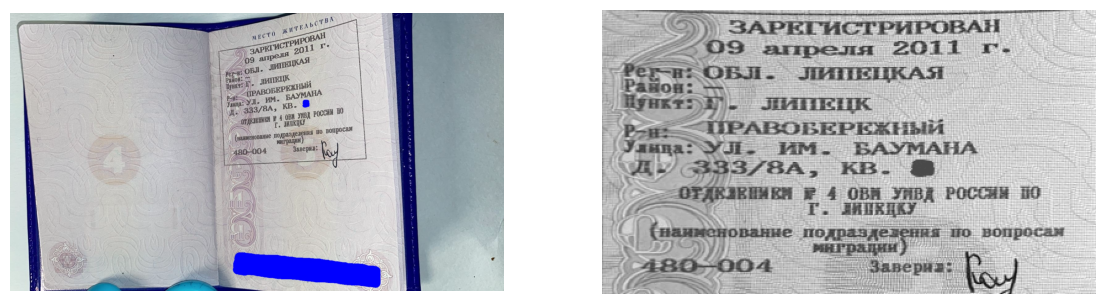

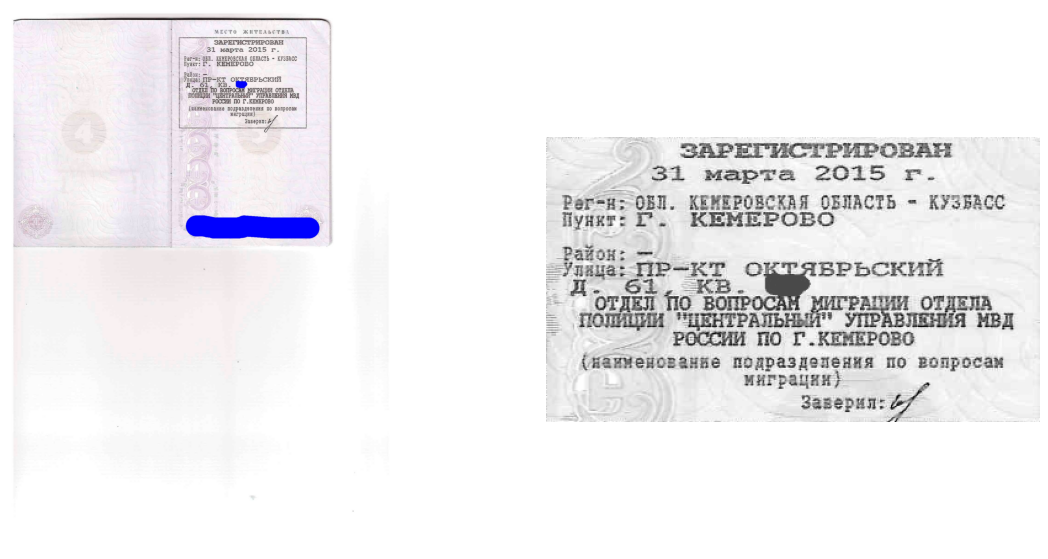

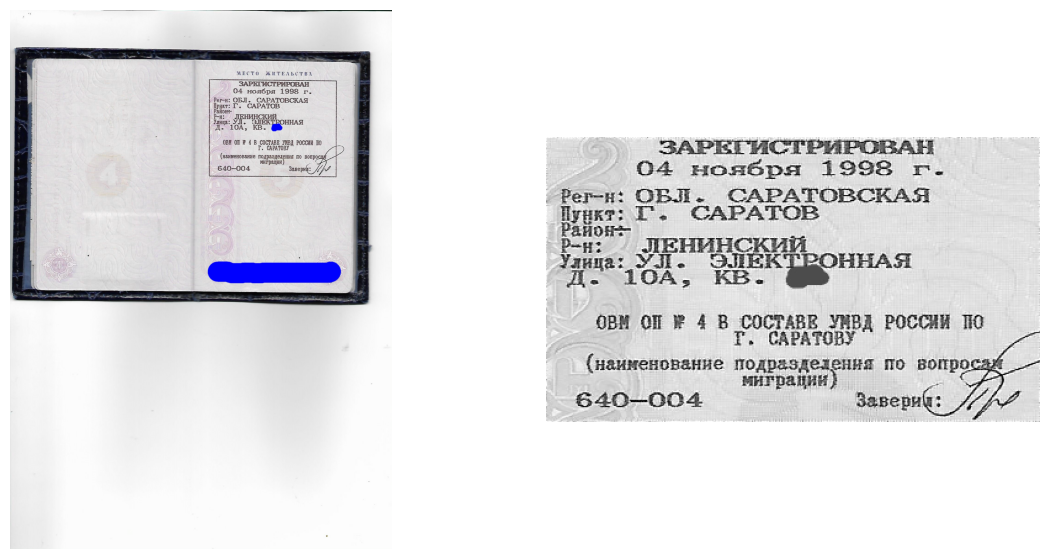

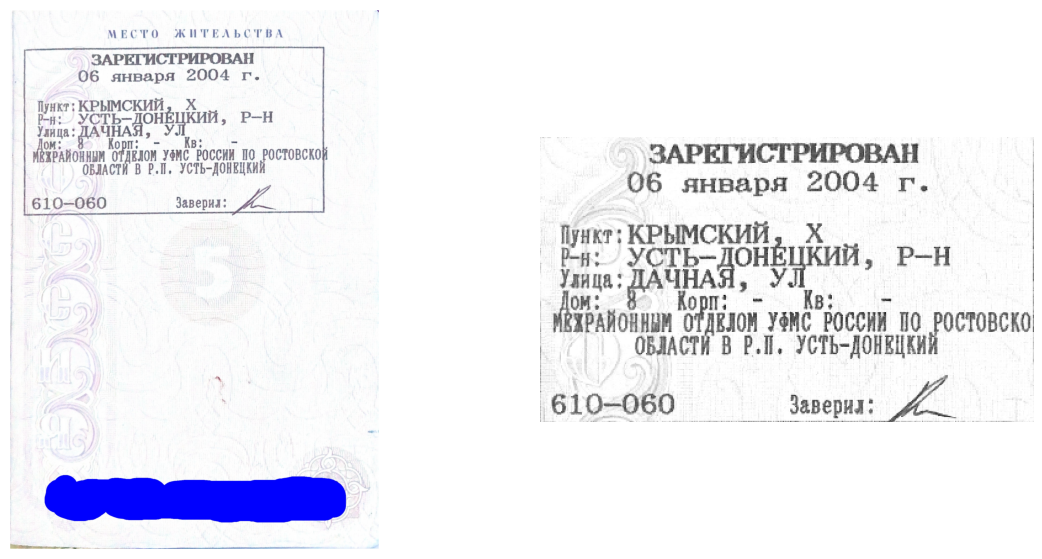

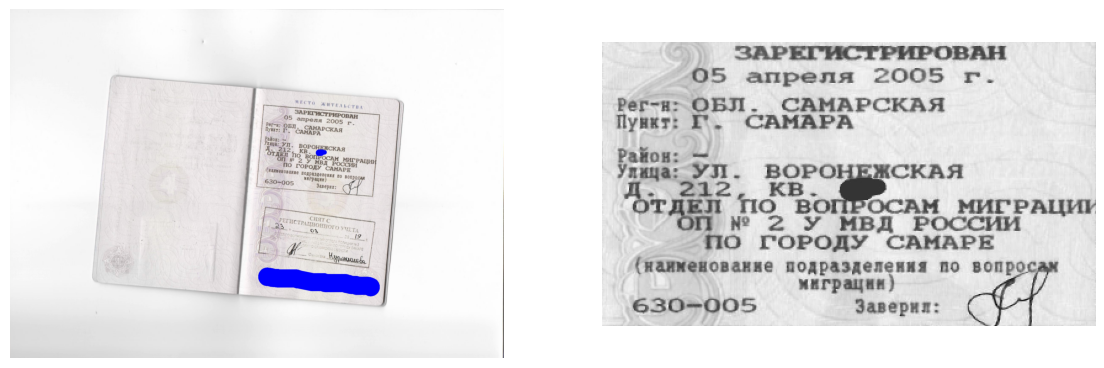

In [23]:
for i in list_img:
    f = images_data.loc[images_data['image_id'] == i, 'file_name'].iloc[0]
    img = cv2.imread('images/'+ f)
    img_blur = img
    
    angle = images_data.loc[images_data['image_id'] == i, 'rotate'].iloc[0]
    if angle == 90:
        img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif angle == 180:
        img = cv2.rotate(img, cv2.ROTATE_180)
    elif angle == -90:
        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_erode = cv2.erode(thresh, np.ones((3, 3), np.uint8), iterations=1)
    contours, hierarchy = cv2.findContours(img_erode,  cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) #  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = sorted(contours, key=cv2.contourArea, reverse=True)
    cnt_new = []
    apd_new = []
    min_pr = 1
    max_pr = 2

    for k in range(0, 50):
        fraction = images_data.loc[images_data['image_id'] == i, 'fraction'].iloc[0]
        area = cv2.contourArea(cnt[k])
        area_img = gray.shape[0]*gray.shape[1]
        (x, y, w, h) = cv2.boundingRect(cnt[k])
      
        if abs(area_img/area - fraction) < 10:  
            if min_pr < w/h < max_pr:
                eps = 0.01
                sm = cv.arcLength(cnt[k], True)
                apd = cv.approxPolyDP(cnt[k], eps*sm, True)
                if len(apd) > 4:
                    while len(apd) > 4:  
                        sm = cv.arcLength(cnt[k], True)
                        apd = cv.approxPolyDP(cnt[k], eps*sm, True)
                        eps += 0.01
                        
                    apd_new.append(apd)
    
    sm_min = cv.arcLength(apd_new[0], True)
    for ap in apd_new:
        sm = cv.arcLength(ap, True)
        if sm <= sm_min:
            sm_min = sm
            apd_fix = ap

    fig = plt.figure(figsize=(14, 7)) 
    rows = 1
    columns = 2
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    fig.add_subplot(rows, columns, 2)
    plt.imshow(pertran(gray, apd_fix), cmap='gray')
    plt.axis('off')
    plt.show()